In [50]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import signal
import scipy
import scipy.io as spio
import cmath 
import math    


In [51]:
# Η συνάρτηση downSample μειώνει την συχνότητα δειγματοληψία ενός σήματος signal κατά έναν παράγοντα nsamp
# κρατώντας μόνο τα δείγματα που είναι πολλάπλάσια του nsamp (0, nsamp, 2*nsamp, ...)
def downSample(signal, nsamp):
    downSampled = []
    for i in range(0, len(signal), nsamp):
        downSampled.append(signal[i])

    return downSampled

In [52]:
def forceFFTSymmetry(X):
    
#forceFFTSymmetry  A function to force conjugate symmetry on an FFT such that when an
# IFFT is performed the result is a real signal.

# The function has been written to replace MATLAB's ifft(X,'symmetric'), as this function
# is not compatible with python 

    XStartFlipped=[]
#XStartFlipped = fliplr(X(2:floor(end/2)));
#X(ceil(end/2)+2:end) = real(XStartFlipped) - sqrt(complex(-1))*imag(XStartFlipped);
    XStartFlipped = np.fliplr(X[1:math.floor(len(X)/2)])
    X[math.ceil(len(X)/2)+1:len(X)] = np.real(XStartFlipped) - complex(0,1)*np.imag(XStartFlipped)


    return X

In [53]:
def awgn(signal, SNR_db):
    # Υπολογισμός της ισχύος του μεταδιδομένου σήματος και της ισχύος θορύβου
    # ώστε να έχουμε το επιθυμητό SNR
    P = np.sum(np.multiply(signal, signal)) / len(signal)
    P_db = 10 * np.log10(P)
    Pn_db = P_db - SNR_db
    Pn = 10 ** (Pn_db * 0.1)

    mu = 0
    sigma = np.sqrt(Pn)
    noise = np.random.normal(mu, sigma, len(signal))
    noisySignal = signal + noise

    return noisySignal

In [54]:
# DMT Tx-Rx parameters
K = 255     #number of subcarriers
Tu = 1/4000  # DMT symbol duration - 4000 frames per second
Fi = 4312.5  # subcarrier spacing
d = 0        #guard interval portion -- zero in this simulation
delta=d*Tu   # guard interval duration
Ts=Tu +delta #actual symbol duration
Ks=2*(K+1)   #FFT size
Fs=Ks*Fi     #Nyquist frequency
T=1/Fs       #time-sampling period




In [55]:
#Gain vector
# It contains the gain for each subcarrier (zero means "don't use")
G=[]
G[:K+1] = [1] * (K+1)
G[0]=0
G[K]=0

        
for i in range(0,31):
    G[i]=0    #voice and uplink band -- not used

G[63]=0       #sub-carrier 64 will be used as pilot

for i in range(179,201):
    G[i]=0  # very noisy band -- not used
    
    
for i in range(201,231):
    G[i]=1.5   # higher gain band
    
for i in range(231,K+1): 
    G[i]=0     # very noisy band -- not used
    
#used_carriers=sum(G~=zeros(1,256));  

used_carriers=0
for i in range(0,K+1):
    if G[i]!=0:
        used_carriers=used_carriers+1
        
        
        

/home/jim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:38: UserWarning: In Matplotlib 3.3 individual lines on a stem plot will be added as a LineCollection instead of individual lines. This significantly improves the performance of a stem plot. To remove this warning and switch to the new behaviour, set the "use_line_collection" keyword argument to True.


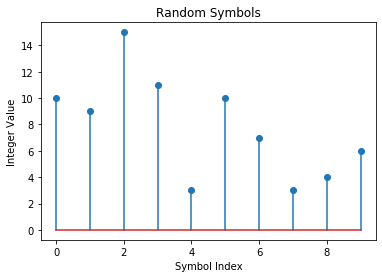

In [56]:
# other parameters
M = 16      # Size of signal constellation per subcarrier - same for all
mb = np.log2(M)  # Number of bits per subcarrier
Ns = 500      # Number of DMT symbols to process. 
# Use a small value of Ns (e.g. 10) for demonstration 
# and a large value (e.g. 500) for BER estimation
n_bits=Ns*mb*used_carriers    # number of bits to generate
Rate=mb*used_carriers/Tu  #actual transmission rate, in bps
nsamp = 16      #Oversampling rate, for analog signal simulation
Tn=T/nsamp     # oversampling period
SNR=5      # signal-to-noise-ratio, in db

## Input bit stream
# Create a binary data stream as a vector.
x = np.random.randint(2, size=int(n_bits)) #random binary data stream


## QAM constellation encoding
# A. Define a vector for mapping bits to symbols using
# orthogonal full-grid constellation and Gray coding. 
# The vector corresponds to 16-QAM constellation.

mapping = [0, 1, 3, 2, 4, 5, 7, 6, 12,13, 15, 14, 8, 9, 11, 10]

# B. Do ordinary binary-to-decimal mapping.

xsym = np.reshape(np.ravel(x), (int(len(x)/mb),int(mb))) 
xsym = xsym.dot(2**np.arange(xsym.shape[1] - 1, -1, -1))

# C. Map from binary coding to Gray coding.
for i in range(len(xsym)):
    xsym[i] = mapping[xsym[i]]


    #matplotlib inline
plt.figure(1) # 16-QAM symbols, mapped on random integers (0..15)
horizontalAxis=[0,1,2,3,4,5,6,7,8,9]
plt.stem(horizontalAxis,xsym[:10]) 
plt.title('Random Symbols')
plt.xlabel('Symbol Index')
plt.ylabel('Integer Value')
plt.show()

In [57]:
# Modulation
# Modulate using 16-QAM.

# first parameter the signal input, second parameter order of QAM
def qammod(x,M):
    
    l = int(np.log2(np.sqrt(M)))
    # create constellation's points in mapping array 
    # gray encoded 
    core = np.array([1+1j, 1-1j, -1+1j, -1-1j])
    mapping = core

    for k in range(1,l):
        mapping = mapping + k * 2 * core[0]
        mapping = np.array([mapping, np.conj(mapping)])
        mapping = np.array([mapping, (-np.conj(mapping))])

    mapping = mapping.flatten().T
    
    # y the modulated signal
    y = []
    for i in range(len(x)):
        y.append(mapping[x[i]])
    
    return y

y = qammod(xsym, M)

/home/jim/.local/lib/python3.7/site-packages/ipykernel_launcher.py:13: ComplexWarning: Casting complex values to real discards the imaginary part
  del sys.path[0]


Text(0, 0.5, 'amplitude')

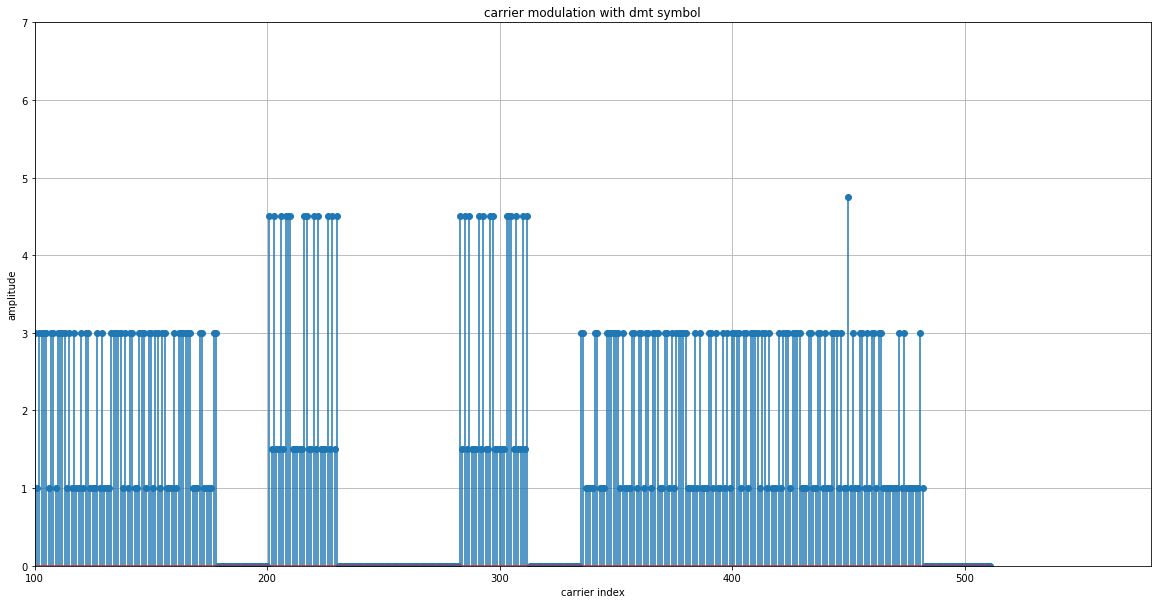

In [58]:
#D. Compute weights over the entire spectrum
#power=sum(np.multiply(y,y))/ len(y)
#amp=sqrt(power)
power= np.sum(np.abs(y) ** 2) / len(y)
amp=np.sqrt(power)
y_mat = []
k=1
for n in range(0,Ns):
    z=np.zeros(2*(K+1))
    for i in range(0,len(G)):
        if G[i]!=0:
            #print(k)
            z[i]=G[i]*y[k-1]
            z[2*(K+1)-i+1]=z[i]
            k=k+1
    z[63]=1.5*amp
    z[2*(K+1)-62]=z[63]  #pilot
    y_mat.extend(z) #y_mat=[y_mat z];

# Stem Plot of a DMT symbol (amplitudes of complex values)
#stem(abs(y_mat(:,1)));
p=np.absolute(y_mat[0:512])
plt.figure(figsize=(20,10))
plt.stem(p,use_line_collection=True)
plt.ylim(0,7)
plt.xlim(100,580)
plt.title("carrier modulation with dmt symbol")
plt.grid()
plt.xlabel("carrier index")
plt.ylabel("amplitude")

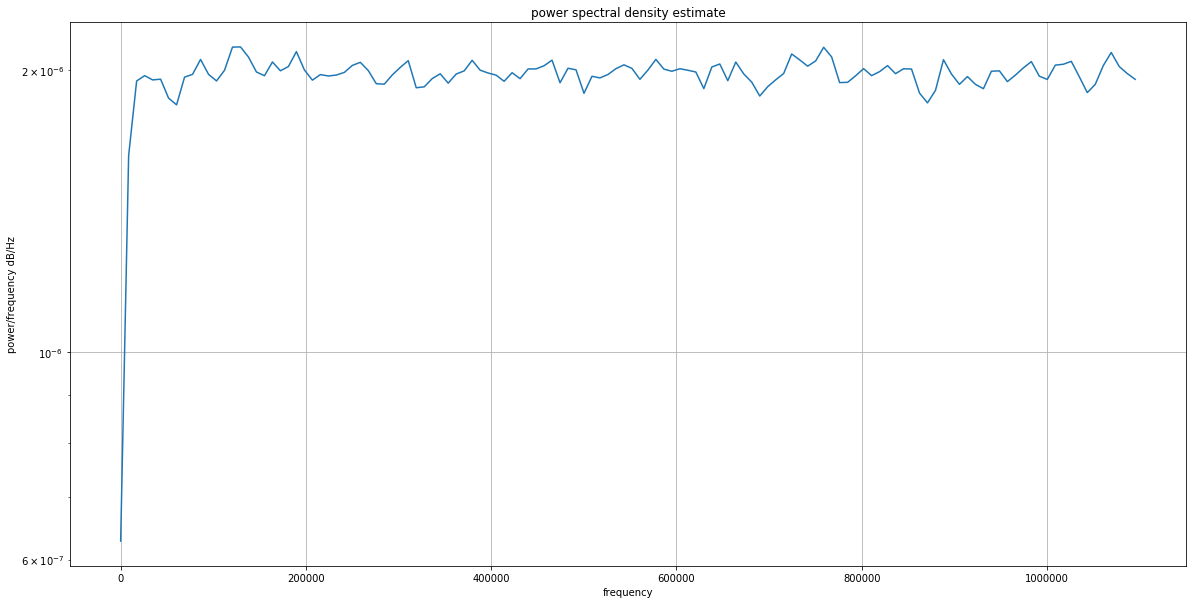

In [78]:
np.shape(y_mat)
s=2*(K+1)*np.fft.ifft(y_mat)
f, Pxx_den = signal.welch(s, fs=1/T)
#xaxis = np.arange(0, len(Pxx_den)/T, 1/T)
sf=len(f)
sp=len(Pxx_den)
plt.figure(figsize=(20,10))  # spectrum of OFDM symbols (T-grid) 
plt.grid()
plt.semilogy(f[0:int(sf/2)], Pxx_den[0:int(sp/2)])
#plt.stem(xaxis,Pxx_den,use_line_collection=True)
plt.title("power spectral density estimate")
plt.xlabel("frequency")
plt.ylabel("power/frequency dB/Hz")
plt.show()

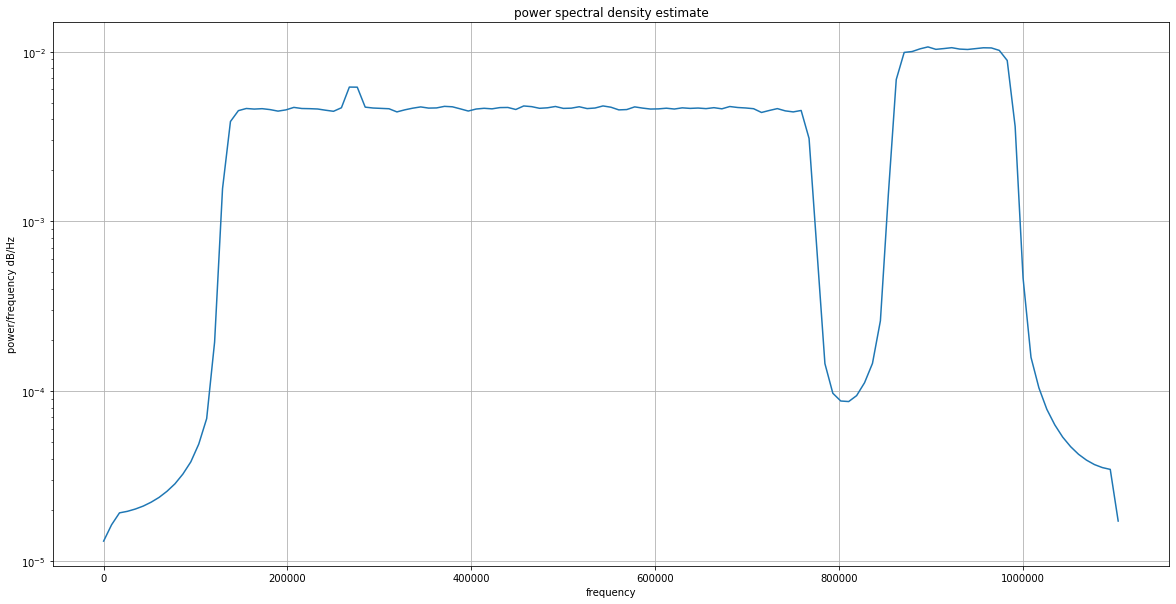

In [59]:
##plot with .mat file due to error 
mat = spio.loadmat('sv.mat', squeeze_me=True) 
s = mat['sv']
#numperseg = 2 *20 # some power of 2
f, Pxx_den = signal.welch(s, fs=1/T)
#xaxis = np.arange(0, len(Pxx_den)/T, 1/T)
plt.figure(figsize=(20,10))  # spectrum of OFDM symbols (T-grid) 
plt.grid()
plt.semilogy(f, Pxx_den)
#plt.stem(xaxis,Pxx_den,use_line_collection=True)
plt.title("power spectral density estimate")
plt.xlabel("frequency")
plt.ylabel("power/frequency dB/Hz")
plt.show()

In [60]:
def interp2(ys, mul):
    # linear extrapolation for last (mul - 1) points
    ys = list(ys)
    ys.append(2*ys[-1] - ys[-2])
    # make interpolation function
    xs = np.arange(len(ys))
    fn = scipy.interpolate.interp1d(xs, ys, kind="cubic")
    # call it on desired data points
    new_xs = np.arange(len(ys) - 1, step=1/mul)
    return fn(new_xs)

def interpol(vector, factor):
    """
    Interpolate, i.e. upsample, a given 1D vector by a specific interpolation factor.
    :param vector: 1D data vector
    :param factor: factor for interpolation (must be integer)
    :return: interpolated 1D vector by a given factor
    """
    x = np.arange(np.size(vector))
    y = vector
    f = scipy.interpolate.interp1d(x, y)

    x_extended_by_factor = np.linspace(x[0], x[-1], np.size(x) * factor)
    y_interpolated = np.zeros(np.size(x_extended_by_factor))

    i = 0
    for x in x_extended_by_factor:
        y_interpolated[i] = f(x)
        i += 1

    return y_interpolated

# interpolation using fir filter of order 2*q*n+1 
# upsample with a factor of q 
# n defaults to 4
def interpolation (x, q):
    cutoff = 0.5 / q
    fir_coef = signal.firwin(2*q*4+2, cutoff)
    interpolated = q * signal.upfirdn(fir_coef, x, q)
    return interpolated 

In [61]:
## D/A simulation -- 
# Perform simple interpolation

mat = spio.loadmat('s_ifft.mat', squeeze_me=True) 
s = mat['s']
s_tilde_up = []
for i in range(len(s)):
    interp = interp2(s[i], nsamp)
    s_tilde_up.append(interp)

s_up = np.concatenate(s_tilde_up)



In [62]:
np.shape(s_tilde_up)

(512, 8000)

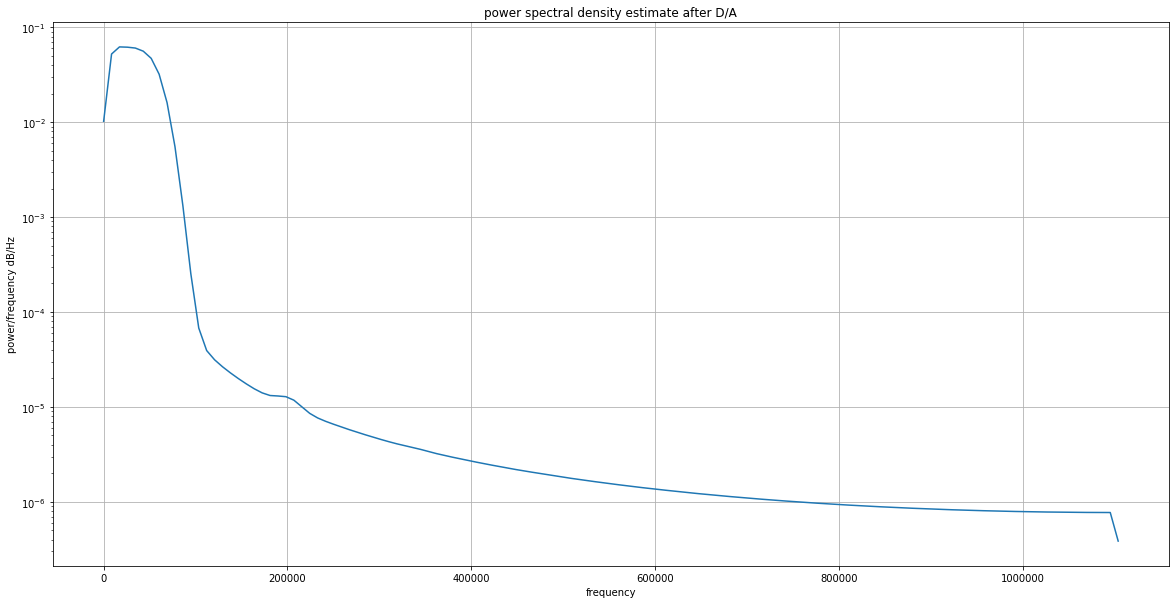

In [63]:
f, Pxx_den = signal.welch(s_up, fs=1/T)
#xaxis = np.arange(0, len(Pxx_den)/T, 1/T)
plt.figure(figsize=(20,10))  # spectrum of OFDM symbols (T-grid) 
plt.grid()
plt.semilogy(f, Pxx_den)
#plt.stem(xaxis,Pxx_den,use_line_collection=True)
plt.title("power spectral density estimate after D/A")
plt.xlabel("frequency")
plt.ylabel("power/frequency dB/Hz")

plt.show()

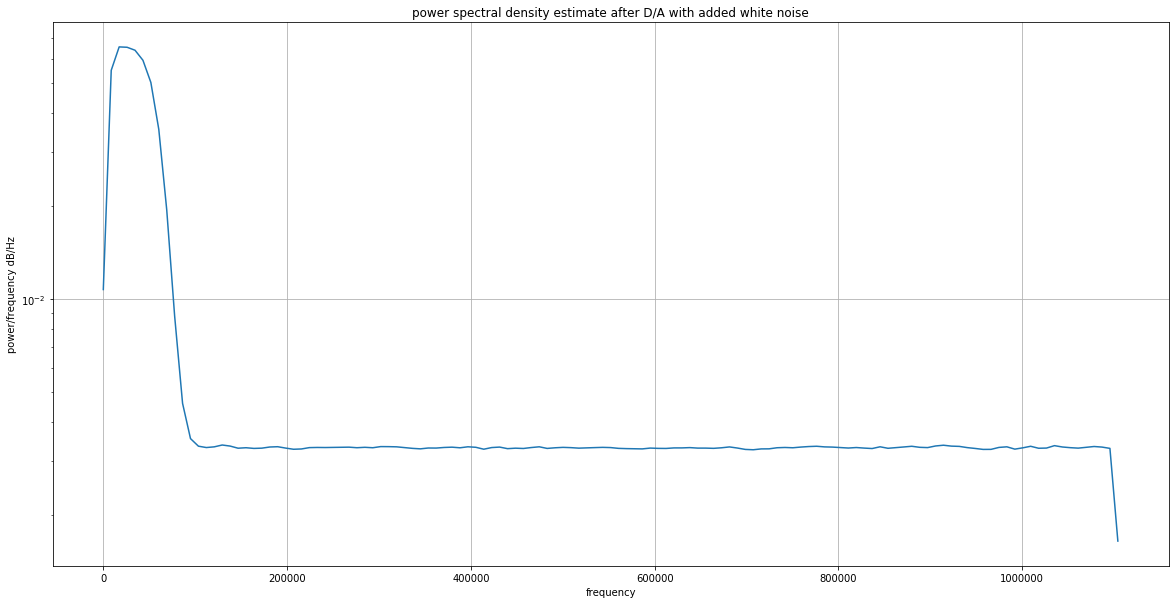

In [64]:
#adding white noise to s_up  with SNR=0.2dB 

SNR = 0.2
noisy = []
noisy=awgn(s_up, SNR)
f, Pxx_den = signal.welch(noisy,fs=1/T)
#xaxis = np.arange(0, len(Pxx_den)/T, 1/T)
plt.figure(figsize=(20,10))  # spectrum of OFDM symbols (T-grid) 
plt.grid()
plt.semilogy(f, Pxx_den)
plt.title("power spectral density estimate after D/A with added white noise")
plt.xlabel("frequency")
plt.ylabel("power/frequency dB/Hz")

plt.show()

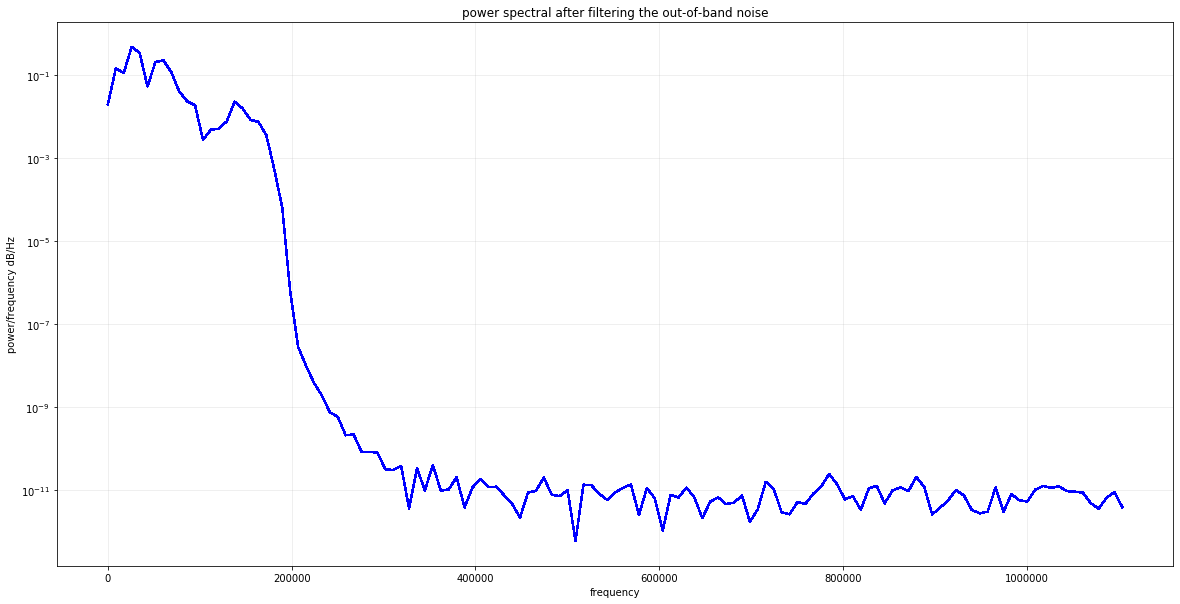

In [65]:
#Filter out the out-of-band noise and downsample the signal  filter-out the bandpass components
#LP (Parks-McClellan) filtering
Fs1=Fs*nsamp
Ks1=Ks*nsamp  # the sampling frequency is changed accordingly
filterOrder=16*nsamp
f1=1.1*Fi*(K+1)/Fs1
f2=1.3*f1
numTaps=filterOrder+1
bands=[0,2*f1,2*f2,0.5]
desired=[1,0]
b = signal.remez(numTaps, bands, desired, maxiter=100)
a=1


#plt.figure(10)
#plt.plot(b)
#plt.grid()
#plt.show()
sr=noisy
sr=np.reshape(sr, (8192,500))


sr_tilde_up = []
delay = filterOrder // 2
for i in range(len(sr[:,0])):
    dummy = sr[0].tolist() + np.zeros(filterOrder).tolist()
    dummy1 = 2 * signal.lfilter(b, a, dummy)
    sr_tilde_up.append(dummy1[delay: delay + len(sr[0])]) #sr_up(:,i)=dummy1(delay+(1:length(sr(:,1))))


f, Pxx = signal.welch(sr_tilde_up,Fs)

plt.figure(figsize=(20,10));  
plt.semilogy(f, np.transpose(Pxx),'b')
plt.grid(alpha=0.25)
#Filter out the out-of-band noise
plt.title("power spectral after filtering the out-of-band noise")
plt.xlabel("frequency")
plt.ylabel("power/frequency dB/Hz")

plt.show()    


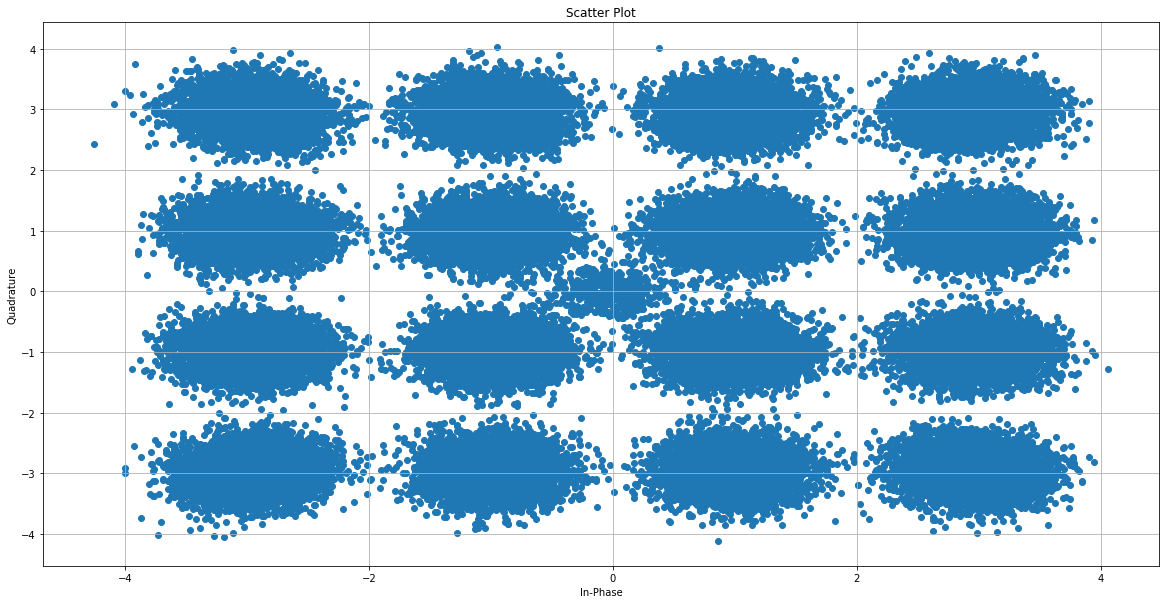

In [68]:
sr_tilde_down = []
sr_tilde_down.append(downSample(sr_tilde_up, nsamp))

np.shape(sr_tilde_down)
sr_down=np.reshape(sr_tilde_down,(512,500))

#f1, Pxx1 = signal.welch(sr_down,Fs)

#plt.figure(figsize=(20,10));  
#plt.semilogy(f1, np.transpose(Pxx1))
#plt.grid(alpha=0.25)
#Filter out the out-of-band noise
#plt.title("power spectral after filtering the out-of-band noise")
#plt.xlabel("frequency")
#plt.ylabel("power/frequency dB/Hz")
#plt.show()   


# Delineate DMT symbols and perform FFT to get the QAM symbols
#yr_mat1=1/Ks*np.fft.fft(sr_down,Ks)   #matlab fft(x,n) different than python
#that is why a am using .mat from matlab
mat = spio.loadmat('yr_mat.mat', squeeze_me=True) 
yr_mat= mat['yr_mat']

#keep only the payload carriers
yr=[]
for n in range(0,len(yr_mat[1,:])):
    for i in range(0,len(G)):
        if G[i]!=0:
            v=yr_mat[i,n]/G[i]
            yr.append(v)



            
plt.figure(figsize=(20,10))
plt.scatter(np.real(yr), np.imag(yr))
plt.grid()
plt.title("Scatter Plot")
plt.xlabel("In-Phase")
plt.ylabel("Quadrature")

plt.show()

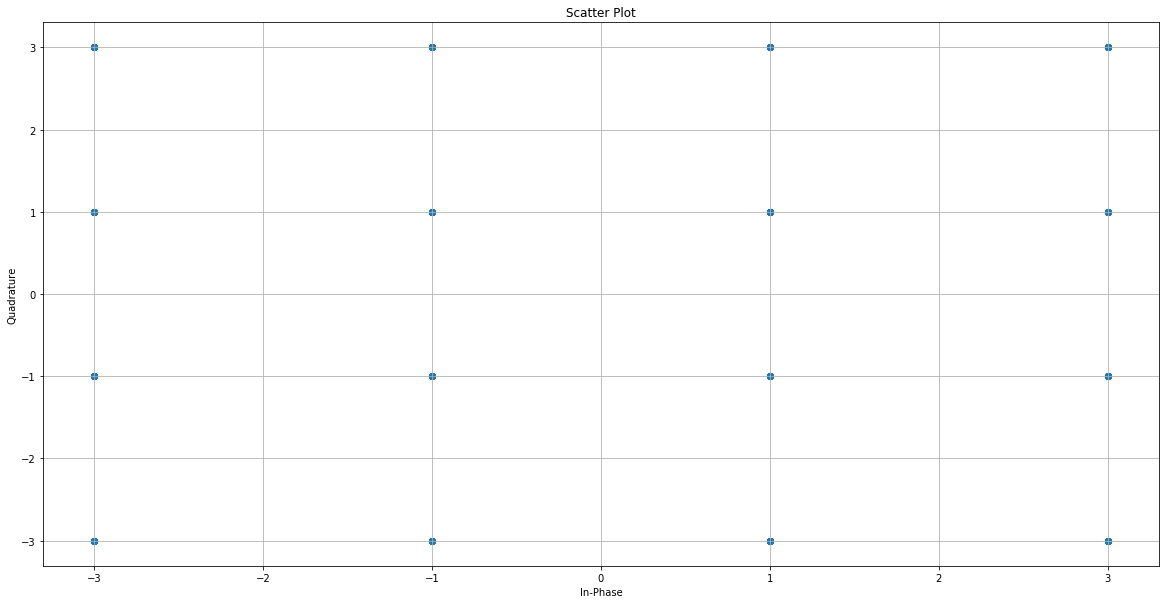

0.23422881355932204


In [67]:
#QAM decoding and error counting
###############################################################
#  Exercise # 2
# Complete the code to implement QAM decoding and error counting.
# For each element of the received vector yr (complex value)
# find the nearest point on the 16-QAM constellation
# Compare the results with the transmitted vector y, 
# count the errors and compute the BER
###############################################################
yi=np.real(yr)
yq=np.imag(yr)  # in phase and quadrature components

l=[-3,-1,1,3]
for n in range(0,len(yi)):
    j=np.argmin(abs(l-yi[n])) #index of min element from difference 
    yi[n]=l[j]                 #set real y as the minimum from difference l-yi[n]
    j=np.argmin(abs(l-yq[n])) 
    yq[n]=l[j]                  #set imaginary y as the minimum from difference l-yq[n]

    
y_f=yi+complex(0,1)*yq          #create final complex array

plt.figure(figsize=(20,10))
plt.scatter(np.real(y_f), np.imag(y_f))
plt.grid()
plt.title("Scatter Plot")
plt.xlabel("In-Phase")
plt.ylabel("Quadrature")

plt.show()

y = qammod(xsym, M)
errors = sum(abs(y_f-y)>0.1)   #calculate errors

BER=errors/(len(y))/mb;  #mb  Number of bits per subcarrier
print(BER)



In [70]:
np.shape(yr_mat)

(512, 500)